In [126]:
import pandas as pd
import torch
import re
import nltk
import nltk.data
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import numpy as np
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from nltk.sentiment import SentimentIntensityAnalyzer
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import datetime
import warnings


pd.options.mode.chained_assignment = None  # default='warn'
warnings.simplefilter(action='ignore', category=FutureWarning)


In [128]:
print(datetime.datetime.now().strftime("%d.%b %Y %H:%M:%S"))

30.Mar 2025 00:13:55


In [130]:
g_set = pd.read_csv('datasets/__sprint2_filtered_usability_review_set_with_sentiment_scores_standardized.csv', encoding='utf-8')
u_set = pd.read_csv('datasets/__sprint2_filtered_functionality_review_set_with_sentiment_scores_standardized.csv', encoding='utf-8')
f_set = pd.read_csv('datasets/__sprint2_filtered_gameplay_review_set_with_sentiment_scores_standardized.csv', encoding='utf-8')

In [131]:
g_set.columns

Index(['Unnamed: 0', 'recommendationid', 'clean_sentence',
       'tokenized_sentence', 'voted_up', 'order', 'informative', 'heuristic',
       'RoBERTa-Twitter_sentiment', 'RoBERTa-Twitter_score', 'VADER_sentiment',
       'VADER_score', 'Sarcasm_Prob', 'RoBERTa-Twitter_score_standardized',
       'VADER_score_standardized'],
      dtype='object')

In [132]:
datasets = [g_set, u_set, f_set]

for i in datasets:
    i['new_RoBERTa_Twitter_score'] = 0
    x = i.loc[(i['RoBERTa-Twitter_sentiment'] == 'Positive'), 'RoBERTa-Twitter_score'] 
    i.loc[(i['RoBERTa-Twitter_sentiment'] == 'Positive'), 'new_RoBERTa_Twitter_score'] = x
    
    x = i.loc[(i['RoBERTa-Twitter_sentiment'] == 'Negative'), 'RoBERTa-Twitter_score'] 
    i.loc[(i['RoBERTa-Twitter_sentiment'] == 'Negative'), 'new_RoBERTa_Twitter_score'] = -x

In [133]:
print(g_set.tail())
#print(u_set.tail())
#print(f_set.tail())

       Unnamed: 0  recommendationid  \
13801      523512          70397678   
13802      523529          70403979   
13803      523530          70403979   
13804      523570          70410353   
13805      523629          70425814   

                                          clean_sentence  \
13801  hours great game hit little something somethin...   
13802  empty shallow terrible story infuriating galax...   
13803  style zero substance form gameplay user interface   
13804                   buddys base use progress mission   
13805                           waste time trying figure   

                                      tokenized_sentence  voted_up  order  \
13801  i only have 35 hours but this is such a great ...         1      2   
13802  empty shallow a terrible story infuriating ui ...         0      0   
13803  its all style and zero substance form gameplay...         0      1   
13804  i have to go to my buddys base and use his to ...         1      8   
13805  just waste m

In [138]:
g_avg_bert = g_set['new_RoBERTa_Twitter_score'].mean()
g_avg_vader = g_set['VADER_score'].mean()
f_avg_bert = f_set['new_RoBERTa_Twitter_score'].mean()
f_avg_vader = f_set['VADER_score'].mean()
u_avg_bert = u_set['new_RoBERTa_Twitter_score'].mean()
u_avg_vader = u_set['VADER_score'].mean()

In [139]:
print(g_set['new_RoBERTa_Twitter_score'].max())

0.9901176


In [140]:
print(g_avg_vader)
print(f_avg_vader)
print(u_avg_vader)

0.0134427929885557
0.13637406542780114
0.026406535206084398


In [142]:
print(g_avg_bert)
print(f_avg_bert)
print(u_avg_bert)

-0.2783602503114588
0.04025030856015453
-0.21733973661923453


In [144]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


#Add new "radar" projection to matplot lib
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


radar_factory(3, frame='polygon')

array([0.       , 2.0943951, 4.1887902])

In [145]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

selected_df = [ g_set, f_set, u_set ]

g_set['roberta_score_normalised'] = scaler.fit_transform(g_set[['new_RoBERTa_Twitter_score']])  
g_set['vader_score_normalised'] = scaler.fit_transform(g_set[['VADER_score']] )

f_set['roberta_score_normalised'] = scaler.fit_transform(f_set[['new_RoBERTa_Twitter_score']] )
f_set['vader_score_normalised'] = scaler.fit_transform(f_set[['VADER_score']] )

u_set['roberta_score_normalised'] =scaler.fit_transform(u_set[['new_RoBERTa_Twitter_score']] )
u_set['vader_score_normalised'] = scaler.fit_transform(u_set[['VADER_score']] )


print(g_avg_bert)
print(f_avg_bert)
print(u_avg_bert)
print(g_set['roberta_score_normalised'].mean())
print(f_set['roberta_score_normalised'].mean())
print(u_set['roberta_score_normalised'].mean())
print(g_set['vader_score_normalised'].mean())
print(f_set['vader_score_normalised'].mean())
print(u_set['vader_score_normalised'].mean())

g_avg_bert = g_set['roberta_score_normalised'].mean()
f_avg_bert = f_set['roberta_score_normalised'].mean()
u_avg_bert = u_set['roberta_score_normalised'].mean()
g_avg_vader = g_set['vader_score_normalised'].mean()
f_avg_vader = f_set['vader_score_normalised'].mean()
u_avg_vader = u_set['vader_score_normalised'].mean()


-0.2783602503114588
0.04025030856015453
-0.21733973661923453
-0.2978376438058341
0.026225784159138604
-0.23564566434011242
0.016034700084301717
0.13524764030342432
0.03126759144836103


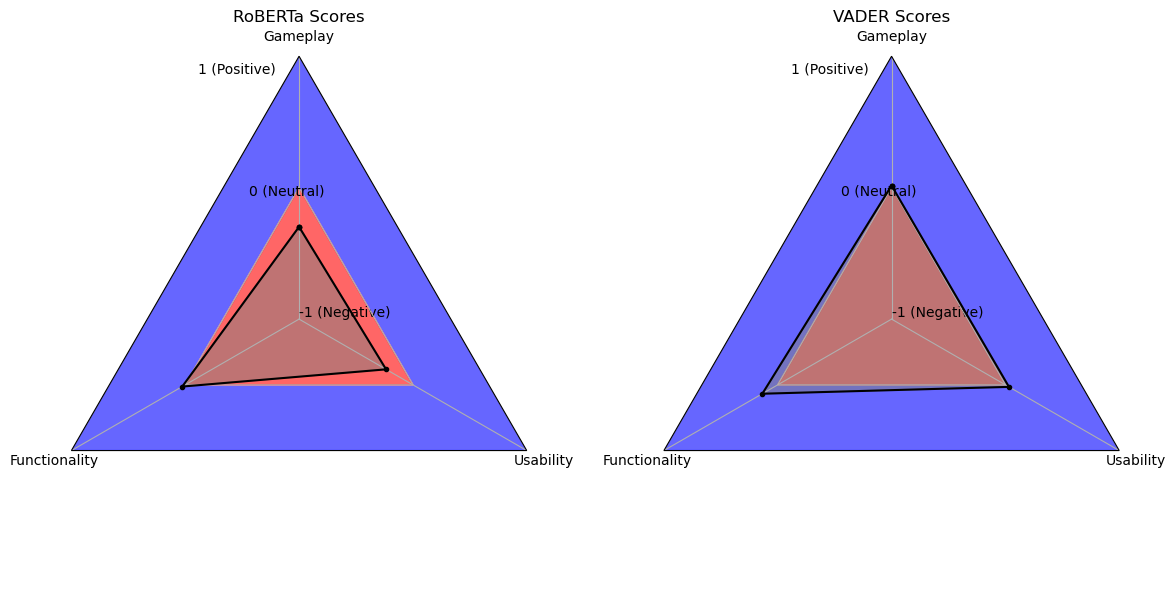

In [147]:

# Define categories (3 metrics for triangular radar chart)
categories = ['Gameplay', 'Functionality', 'Usability']


# Sample values ranging from -1 to 1
values0 = [0,0,0]  # Dataset 1
values0 += [values0[0]]
values9 = [1,1,1]  # Dataset 1
values9 += [values9[0]]

values1 = [g_avg_bert, f_avg_bert, u_avg_bert]  # Dataset 1
values2 = [g_avg_vader, f_avg_vader, u_avg_vader]  # Dataset 2

# Ensure the data closes the radar chart
values1 += [values1[0]]
values2 += [values2[0]]

# Generate angles for the radar chart (3 axes for triangle shape)
angles = np.linspace(0, 2 * np.pi, len(categories) + 1, endpoint=True)

# Create subplots for two radar charts
fig, axs = plt.subplots(1, 2, subplot_kw=dict(projection='radar'), figsize=(12,7))
#fig, axs = plt.subplots(1, 2, subplot_kw=dict(projection='radar'), figsize=(12,7))

# Function to adjust radial limits for values between -1 and 1
def adjust_polar_axis(ax):
    ax.set_ylim(-1, 1)  # Set limits to allow negative values
    ax.set_yticks([-1, 0, 1])  # Define y-axis ticks
    ax.set_yticklabels(['-1 (Negative)',  '0 (Neutral)', '1 (Positive)'])  # Labels for y-axis
    ax.set_xticks(angles[:-1])  # Set category labels at correct angles
    ax.set_xticklabels(categories)

# Plot first triangular radar chart
axs[0].fill(angles, values9, color='b', alpha=0.6)
axs[0].fill(angles, values0, color='white', alpha=1)
axs[0].fill(angles, values0, color='r', alpha=0.6)

axs[0].plot(angles, values1, marker='.', linestyle='solid', color='black', label="BERT Scores")
axs[0].fill(angles, values1, color='grey', alpha=.5)
adjust_polar_axis(axs[0])
axs[0].set_title("RoBERTa Scores")

# Plot second triangular radar chart
axs[1].fill(angles, values9, color='b', alpha=0.6)
axs[1].fill(angles, values0, color='white', alpha=1)
axs[1].fill(angles, values0, color='r', alpha=0.6)

axs[1].plot(angles, values2, marker='.', linestyle='solid', color='black', label="VADER Scores")
axs[1].fill(angles, values2, color='grey', alpha=.5)
adjust_polar_axis(axs[1])
axs[1].set_title("VADER Scores")

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('charts/sprint3_roberta_vader_comparison_plots.png')
plt.show()

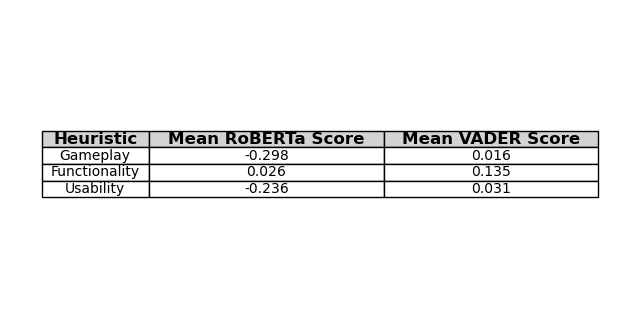

In [150]:

# Define table data
data = [
    #["Heuristic", "Mean BERT Score", "Mean VADER Score"],
    ["Gameplay", f"{g_avg_bert:.3f}", f"{g_avg_vader:.3f}"],
    ["Functionality", f"{f_avg_bert:.3f}", f"{f_avg_vader:.3f}"],
    ["Usability",f"{u_avg_bert:.3f}", f"{u_avg_vader:.3f}"]
]

# Define column labels
columns = ["Heuristic", "Mean RoBERTa Score", "Mean VADER Score"]

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create table
table = ax.table(cellText=data, colLabels=columns, cellLoc='center', loc='center')

# Styling the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([0, 1, 2])  # Adjust column widths

# Style the header row (make it bold and set background color to grey)
for key, cell in table.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_fontsize(12)
        cell.set_text_props(weight='bold')
        cell.set_facecolor('lightgrey')

# Display table
plt.savefig('charts/sprint3_mean_sentiment_score_results_table.png')
plt.show()


In [152]:
u_set.tail(10)

,Unnamed: 0,recommendationid,clean_sentence,tokenized_sentence,voted_up,order,informative,heuristic,RoBERTa-Twitter_sentiment,RoBERTa-Twitter_score,VADER_sentiment,VADER_score,Sarcasm_Prob,RoBERTa-Twitter_score_standardized,VADER_score_standardized,new_RoBERTa_Twitter_score,roberta_score_normalised,vader_score_normalised
32598,523411,70362588,good game minimal crashes,very good game minimal crashes,1,0,1.0,"[('F',)]",Positive,0.965543,Positive,0.4927,0.854848,0.924660,0.500730,0.965543,0.974859,0.500730
32599,523462,70389091,really lot address issues launch,they really did a lot to address the issues wi...,1,0,1.0,"[('F',)]",Positive,0.677112,Neutral,0.0000,0.940261,0.002398,0.004682,0.677112,0.679693,0.004682
32600,523481,70390191,devs constantly working improve game release u...,the devs are constantly working to improve thi...,1,7,1.0,"[('F',)]",Positive,0.801483,Positive,0.4404,0.713338,0.421547,0.448075,0.801483,0.806968,0.448075
32601,523486,70391118,became good game updates added tons things rea...,it became a very good game after the updates t...,1,0,1.0,"[('F',)]",Positive,0.973602,Positive,0.4927,0.588350,0.949374,0.500730,0.973602,0.983106,0.500730
32602,523536,70405344,game really great bugs,the game is really great just a few bugs here ...,1,0,1.0,"[('F',)]",Positive,0.928100,Positive,0.6590,0.636756,0.809837,0.668160,0.928100,0.936542,0.668160
32603,523539,70405344,saying bugs sometimes annoying like space anom...,just saying the bugs sometimes be annoying lik...,1,3,1.0,"[('F',)]",Negative,0.845085,Negative,-0.3818,0.462029,0.555260,-0.379713,-0.845085,-0.878050,-0.379713
32604,523545,70409796,expecting hardcore mass effect run gun mmo typ...,if you are expecting a hardcore mass effect ru...,1,1,1.0,"[('F',)]",Negative,0.778246,Negative,-0.3400,0.061843,0.350287,-0.337629,-0.778246,-0.809650,-0.337629
32605,523605,70420816,really enjoyed gameplay,but for now i really enjoyed the gameplay 3,1,2,1.0,"[('F',)]",Positive,0.971733,Positive,0.7086,0.140399,0.943644,0.718097,0.971733,0.981194,0.718097
32606,523613,70425169,runs thats matters,it runs and thats what matters,1,2,1.0,"[('F',)]",Positive,0.836711,Neutral,0.0258,0.329568,0.529578,0.030657,0.836711,0.843019,0.030657
32607,523618,70425814,criticisms many asteroids asteroids spaced bet...,criticisms too many asteroids asteroids should...,1,2,1.0,"[('F',)]",Negative,0.658370,Positive,0.2500,0.534200,-0.017331,0.256381,-0.658370,-0.686975,0.256381


<Axes: >

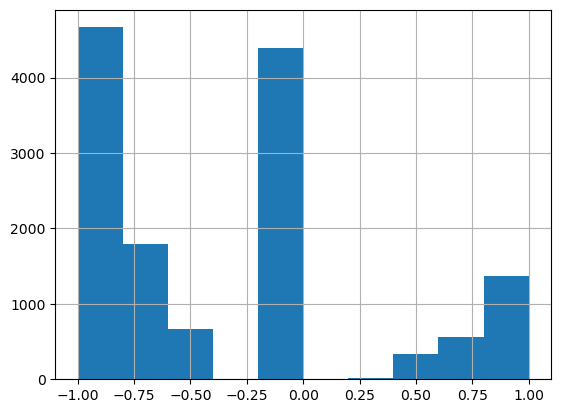

In [153]:
g_set['roberta_score_normalised'].hist()

In [155]:
print(len(g_set['roberta_score_normalised']))
print(len(f_set['roberta_score_normalised']))
print(len(u_set['roberta_score_normalised']))
print(len(g_set['vader_score_normalised']))
print(len(f_set['vader_score_normalised']))
print(len(u_set['vader_score_normalised']))

13806
96809
32608
13806
96809
32608


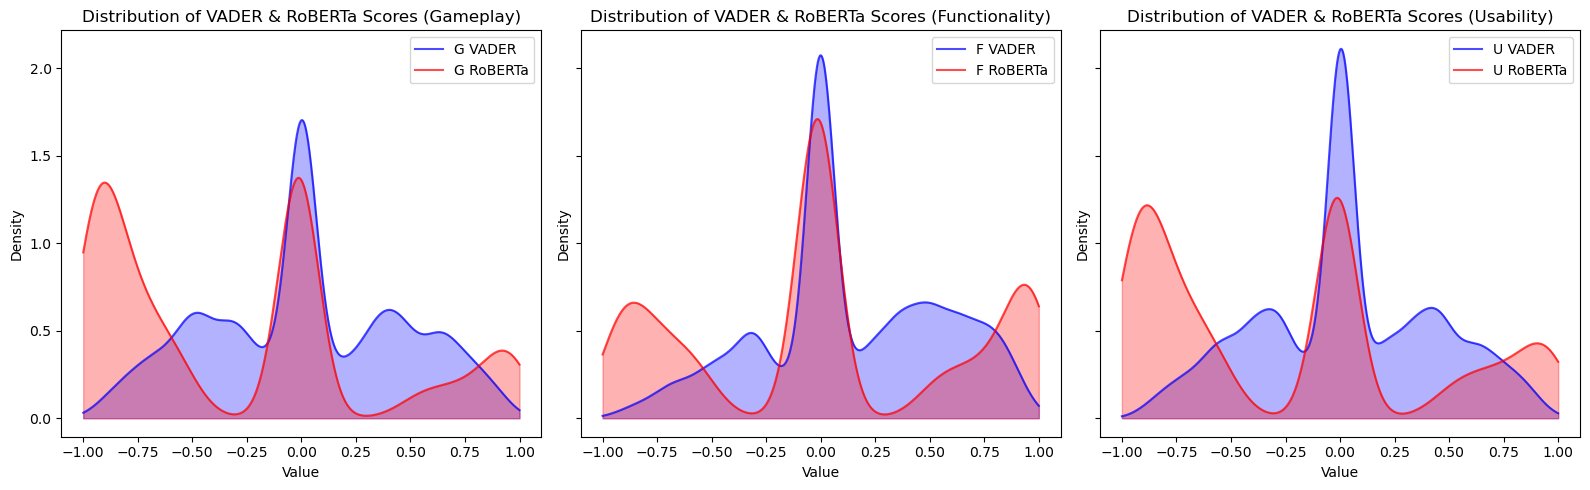

In [157]:
from scipy.stats import gaussian_kde

num= len(g_set['roberta_score_normalised'])

g_sample = g_set.sample(n=num, random_state=1)
f_sample = f_set.sample(n=num, random_state=1)
u_sample = u_set.sample(n=num, random_state=1)



# Generate sample data ensuring numerical types
np.random.seed(1)
df = pd.DataFrame({
    'G VADER': g_sample['vader_score_normalised'].astype(float).to_numpy(),
    'G RoBERTa': g_sample['roberta_score_normalised'].astype(float).to_numpy(),
    'F VADER': f_sample['vader_score_normalised'].astype(float).to_numpy(),
    'F RoBERTa': f_sample['roberta_score_normalised'].astype(float).to_numpy(),
    'U VADER': u_sample['vader_score_normalised'].astype(float).to_numpy(),
    'U RoBERTa': u_sample['roberta_score_normalised'].astype(float).to_numpy()
})

# Define feature pairs for each subplot
feature_pairs = [('G VADER', 'G RoBERTa'), ('F VADER', 'F RoBERTa'), ('U VADER', 'U RoBERTa')]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)


index = 0
chart_titles = ['Distribution of VADER & RoBERTa Scores (Gameplay)',
               'Distribution of VADER & RoBERTa Scores (Functionality)',
               'Distribution of VADER & RoBERTa Scores (Usability)']

# Loop through feature pairs and create KDE plots
for ax, (feature_x, feature_y) in zip(axs, feature_pairs):
    # Compute KDE using scipy for both features
    x_vals = np.linspace(-1, 1, 1000)
    
    kde_x = gaussian_kde(df[feature_x])
    kde_y = gaussian_kde(df[feature_y])
    
    y_x = kde_x(x_vals)
    y_y = kde_y(x_vals)

    # Plot both KDE curves
    ax.plot(x_vals, y_x, label=feature_x, color="blue", alpha=0.7)
    ax.fill_between(x_vals, y_x, alpha=0.3, color="blue")

    ax.plot(x_vals, y_y, label=feature_y, color="red", alpha=0.7)
    ax.fill_between(x_vals, y_y, alpha=0.3, color="red")

    # Labels and title for each subplot
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.set_title(f"{chart_titles[index]}")
    ax.legend()
    index +=1

# Adjust layout and show plot
plt.tight_layout()
plt.savefig("charts/sprint3_roberta_and_vader_score_distribution_charts.png")
plt.show()

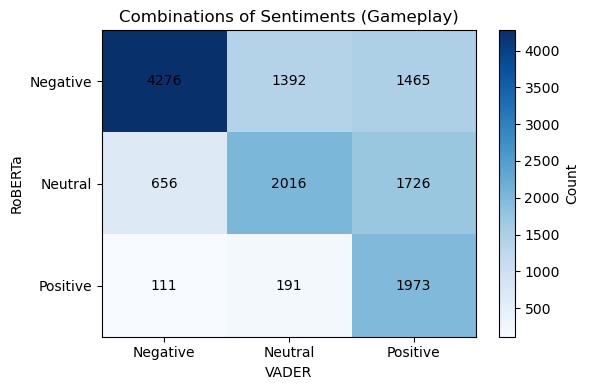

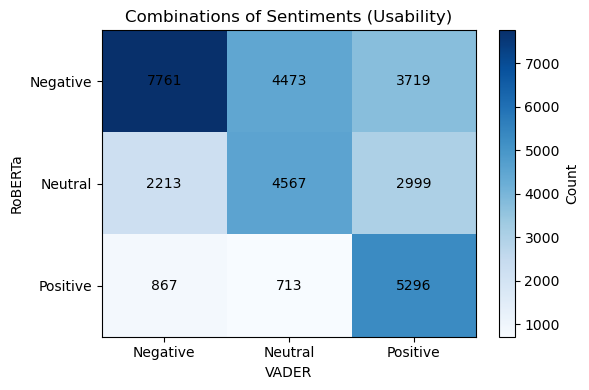

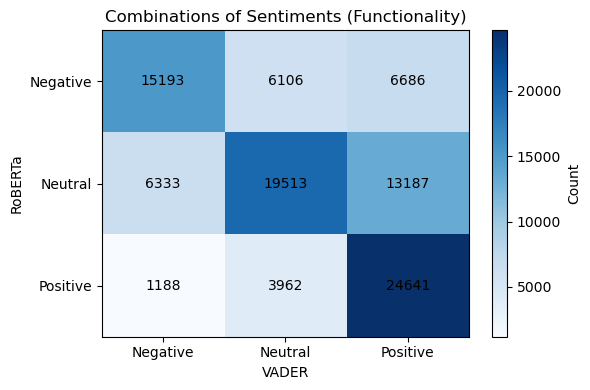

In [162]:
dataset_names = ['Gameplay','Usability','Functionality']

for d in range(len(datasets)):
    # Count combinations
    combo_counts = datasets[d].groupby(['RoBERTa-Twitter_sentiment', 'VADER_sentiment']).size().unstack(fill_value=0)
    
    # Plot as heatmap
    plt.figure(figsize=(6, 4))
    plt.imshow(combo_counts, cmap='Blues', aspect='auto')
    plt.title('Combinations of Sentiments (' +dataset_names[d]+')')
    plt.xlabel('VADER')
    plt.ylabel('RoBERTa')
    plt.xticks(ticks=range(len(combo_counts.columns)), labels=combo_counts.columns)
    plt.yticks(ticks=range(len(combo_counts.index)), labels=combo_counts.index)
    
    # Add count annotations
    for i in range(len(combo_counts.index)):
        for j in range(len(combo_counts.columns)):
            count = combo_counts.iloc[i, j]
            plt.text(j, i, str(count), ha='center', va='center', color='black')
    
    plt.colorbar(label='Count')
    plt.tight_layout()
    plt.savefig("charts/sprint3_sentiment_matched_classification_prediction_matrix"+dataset_names[d]+".png")
    plt.show()
    

In [163]:

for d in range(len(datasets)):
    combo_counts = datasets[d].groupby(['RoBERTa-Twitter_sentiment', 'VADER_sentiment']).size().reset_index(name='count')
    total = len(datasets[d])

    # Boolean mask for matches
    datasets[d]['match'] = datasets[d]['RoBERTa-Twitter_sentiment'] == datasets[d]['VADER_sentiment']

    # Count matches and mismatches
    correct = datasets[d]['match'].sum()
    incorrect = total - correct
    
    # Calculate percentages
    correct_pct = (correct / total) * 100
    incorrect_pct = (incorrect / total) * 100
    
    print(f"✅ {dataset_names[d]} Sentiment Matches: {correct} ({correct_pct:.2f}%)")
    print(f"❌ {dataset_names[d]} Sentiment Misatches: {incorrect} ({incorrect_pct:.2f}%)")

    # Add a column to mark whether each combination is a match
    combo_counts['is_match'] = combo_counts['RoBERTa-Twitter_sentiment'] == combo_counts['VADER_sentiment']
    
    # Add percentage of total
    combo_counts['percentage'] = (combo_counts['count'] / total) * 100
    
    print(combo_counts)

✅ Gameplay Sentiment Matches: 8265 (59.87%)
❌ Gameplay Sentiment Misatches: 5541 (40.13%)
  RoBERTa-Twitter_sentiment VADER_sentiment  count  is_match  percentage
0                  Negative        Negative   4276      True   30.972041
1                  Negative         Neutral   1392     False   10.082573
2                  Negative        Positive   1465     False   10.611328
3                   Neutral        Negative    656     False    4.751557
4                   Neutral         Neutral   2016      True   14.602347
5                   Neutral        Positive   1726     False   12.501811
6                  Positive        Negative    111     False    0.803998
7                  Positive         Neutral    191     False    1.383456
8                  Positive        Positive   1973      True   14.290888
✅ Usability Sentiment Matches: 17624 (54.05%)
❌ Usability Sentiment Misatches: 14984 (45.95%)
  RoBERTa-Twitter_sentiment VADER_sentiment  count  is_match  percentage
0            